## Setup: Load Image

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import urllib.request
import re

# Load image from file path or Google Drive URL
def load_image(path_or_url):
    if path_or_url.startswith("http"):
        # Google Drive: convert share link to direct download
        match = re.search(r"/d/([a-zA-Z0-9_-]+)", path_or_url)
        if match:
            file_id = match.group(1)
            url = f"https://drive.google.com/uc?export=download&id={file_id}"
        else:
            url = path_or_url
        with urllib.request.urlopen(url) as resp:
            img = Image.open(BytesIO(resp.read())).convert("RGB")
    else:
        img = Image.open(path_or_url).convert("RGB")
    return np.array(img, dtype=np.float64) / 255.0

# Google Drive link: B0006314.jpg
IMAGE_URL = "https://drive.google.com/file/d/1oeW5qR_ydKkQOO5eaFtyvMiHBRiC6djD/view?usp=sharing"

try:
    img_rgb = load_image(IMAGE_URL)
    print("Loaded from Google Drive")
except Exception as e:
    # Fallback: create a synthetic gradient image for demo
    h, w = 200, 300
    xx, yy = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
    lum = 0.3 + 0.5 * xx + 0.2 * np.sin(4 * yy)
    img_rgb = np.stack([lum, lum * 0.9, lum * 0.8], axis=-1)
    img_rgb = np.clip(img_rgb, 0, 1)
    print(f"Using synthetic demo image ({e})")

h, w = img_rgb.shape[:2]

Loaded from Google Drive


## Helper Functions: Luminance, AE Weight Maps (ExposureLAB), Histograms, IQR

In [8]:
def rgb_to_luminance(img):
    """Linear luminance Y = 0.2126*R + 0.7152*G + 0.0722*B (values in [0,1])."""
    return 0.2126 * img[..., 0] + 0.7152 * img[..., 1] + 0.0722 * img[..., 2]

# ---- ExposureLAB AE algorithm weight maps ----

def compute_fullframe_weights(height, width):
    """Full frame (Global): all pixels weighted equally. ExposureLAB: algoWeights[i] = 1 for in-range."""
    return np.ones((height, width)) / (height * width)

def compute_roi_weights(height, width):
    """ROI (Semantic): matrix metering from ExposureLAB. Weight = 1 - (dist/maxDist)*0.7."""
    center_x, center_y = width / 2, height / 2
    max_dist = np.sqrt(0.5**2 + 0.5**2)
    yy, xx = np.ogrid[:height, :width]
    dx = (xx - center_x) / width
    dy = (yy - center_y) / height
    dist = np.sqrt(dx**2 + dy**2)
    weights = np.maximum(0, 1.0 - (dist / max_dist) * 0.7)
    weights /= weights.sum()
    return weights

def compute_saliency_weights(luminance, roi_weights):
    """Saliency: emphasize pixels whose luminance deviates from weighted mean, modulated by ROI weights.
    ExposureLAB: dev = |L - mean|, sal = dev/maxDev, algoWeights = sal * roi_weights."""
    roi_flat = roi_weights.ravel()
    lum_flat = luminance.ravel()
    mean = np.average(lum_flat, weights=roi_flat)
    dev = np.abs(lum_flat - mean)
    max_dev = dev.max()
    sal = dev / max_dev if max_dev > 0 else np.ones_like(dev)
    weights = (sal * roi_flat).reshape(luminance.shape)
    if weights.sum() > 0:
        weights /= weights.sum()
    return weights

def weighted_histogram(luminance, weights, bins=256):
    """Build weighted histogram of luminance in [0,1]. Returns (hist, cdf)."""
    lum_flat = luminance.ravel()
    w_flat = weights.ravel()
    lum_clamped = np.clip(lum_flat, 0, 1)
    bin_idx = np.clip((lum_clamped * (bins - 1)).astype(int), 0, bins - 1)
    hist = np.zeros(bins)
    np.add.at(hist, bin_idx, w_flat)
    cdf = np.cumsum(hist)
    return hist, cdf

def compute_percentile(cdf, p, min_val=0, max_val=1):
    bins = len(cdf)
    total = cdf[-1]
    if total == 0:
        return min_val
    target = p * total
    idx = np.searchsorted(cdf, target)
    idx = min(idx, bins - 1)
    norm_val = (idx + 0.5) / bins
    return min_val + norm_val * (max_val - min_val)

def compute_iqr_bounds(cdf, min_val=0, max_val=1):
    """1.5*IQR rule: lower = Q1 - 1.5*IQR, upper = Q3 + 1.5*IQR."""
    total = cdf[-1]
    if total == 0 or not np.isfinite(total):
        return min_val, max_val
    q1 = compute_percentile(cdf, 0.25, min_val, max_val)
    q3 = compute_percentile(cdf, 0.75, min_val, max_val)
    iqr = q3 - q1
    lower = max(min_val, q1 - 1.5 * iqr)
    upper = min(max_val, q3 + 1.5 * iqr)
    return lower, upper

def adjusted_histogram(luminance, weights, lower, upper, bins=256):
    """Histogram with weights zeroed for pixels outside [lower, upper]."""
    lum_flat = luminance.ravel()
    w_flat = weights.ravel().copy()
    out_of_range = (lum_flat < lower) | (lum_flat > upper)
    w_flat[out_of_range] = 0
    lum_clamped = np.clip(lum_flat, 0, 1)
    bin_idx = np.clip((lum_clamped * (bins - 1)).astype(int), 0, bins - 1)
    hist = np.zeros(bins)
    np.add.at(hist, bin_idx, w_flat)
    return hist

## Visualization: 3 Pipelines × 3 Stages (Full frame, ROI, Saliency)

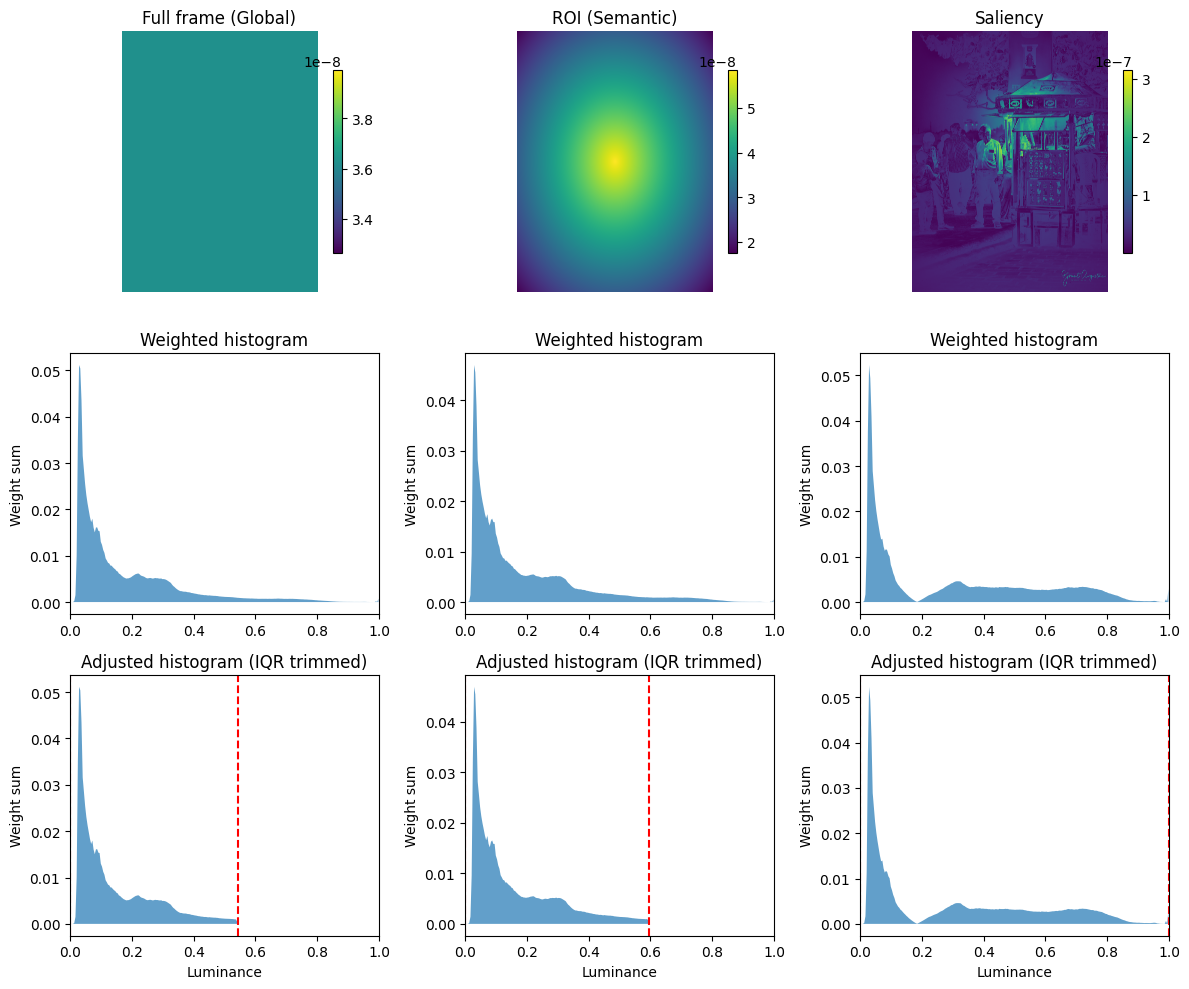

In [9]:
luminance = rgb_to_luminance(img_rgb)
bins = 256
bin_edges = np.linspace(0, 1, bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# ExposureLAB AE algorithm weight maps: Full frame, ROI (matrix metering), Saliency
roi_weights = compute_roi_weights(h, w)
weight_maps = {
    "Full frame (Global)": compute_fullframe_weights(h, w),
    "ROI (Semantic)": roi_weights,
    "Saliency": compute_saliency_weights(luminance, roi_weights),
}

fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for col, (name, weights) in enumerate(weight_maps.items()):
    hist, cdf = weighted_histogram(luminance, weights, bins)
    lower, upper = compute_iqr_bounds(cdf, 0, 1)
    adj_hist = adjusted_histogram(luminance, weights, lower, upper, bins)

    # Row 0: Weight map
    im = axes[0, col].imshow(weights, cmap="viridis")
    axes[0, col].set_title(name)
    axes[0, col].axis("off")
    plt.colorbar(im, ax=axes[0, col], shrink=0.7)

    # Row 1: Weighted histogram
    axes[1, col].fill_between(bin_centers, hist, alpha=0.7)
    axes[1, col].set_xlim(0, 1)
    axes[1, col].set_title("Weighted histogram")
    axes[1, col].set_ylabel("Weight sum")

    # Row 2: Adjusted histogram (IQR trimmed) with fence lines
    axes[2, col].fill_between(bin_centers, adj_hist, alpha=0.7)
    axes[2, col].axvline(lower, color="red", linestyle="--", label="IQR lower")
    axes[2, col].axvline(upper, color="red", linestyle="--", label="IQR upper")
    axes[2, col].set_xlim(0, 1)
    axes[2, col].set_title("Adjusted histogram (IQR trimmed)")
    axes[2, col].set_xlabel("Luminance")
    axes[2, col].set_ylabel("Weight sum")

plt.tight_layout()
plt.show()